## 0. Configuration (⚙️ SET THIS BEFORE EACH RUN)

**IMPORTANT:** Change `ANALYSIS_STAGE` before each run to get a new random sample and save results separately.

In [1]:
# =============================================================================
# ⚙️ ANALYSIS CONFIGURATION
# =============================================================================
# Change this value before each run to get a new random sample and separate reports
# Examples: 1, 2, 3, 4, etc.

ANALYSIS_STAGE = 2  # 👈 CHANGE THIS BEFORE EACH RUN!

# =============================================================================
# Derived parameters (DO NOT EDIT)
RANDOM_SEED = ANALYSIS_STAGE * 100  # Different seed for each stage
STAGE_SUFFIX = f"_stage{ANALYSIS_STAGE}"  # Suffix for report filenames

# MFA configuration
USE_MFA_ALIGNMENT = True  # Toggle NEW (MFA) vs OLD (proportional) algorithm
MFA_BIN = "/Volumes/SSanDisk/SpeechRec-German/miniforge/envs/mfa310/bin/mfa"
MFA_DICT = "german_mfa"
MFA_MODEL = "german_mfa"

print(f"{'='*80}")
print(f"🔬 ANALYSIS CONFIGURATION")
print(f"{'='*80}")
print(f"  Stage: {ANALYSIS_STAGE}")
print(f"  Random seed: {RANDOM_SEED}")
print(f"  Report suffix: {STAGE_SUFFIX}")
print(f"  Reports will be saved as: phoneme_analysis_*{STAGE_SUFFIX}.csv")
print(f"{'='*80}")
print()
print(f"💡 TIP: To run a new analysis with different 1000 sentences:")
print(f"     1. Change ANALYSIS_STAGE to {ANALYSIS_STAGE + 1}")
print(f"     2. Run 'Restart & Run All'")
print(f"{'='*80}")

🔬 ANALYSIS CONFIGURATION
  Stage: 2
  Random seed: 200
  Report suffix: _stage2
  Reports will be saved as: phoneme_analysis_*_stage2.csv

💡 TIP: To run a new analysis with different 1000 sentences:
     1. Change ANALYSIS_STAGE to 3
     2. Run 'Restart & Run All'


# Deep Phoneme Mismatch Analysis

## Comprehensive Analysis of Phoneme Recognition Errors

This notebook performs an in-depth analysis of phoneme mismatches between:
- **Expected phonemes**: extracted from text using G2P (Grapheme-to-Phoneme) conversion
- **Recognized phonemes**: extracted from audio using wav2vec2 model

### Dataset
- **Source**: TV-2021.02-Neutral (hochdeutsch pronunciation)
- **Sample size**: 1000 recordings (900 random + 100 with loanwords)
- **Special focus**: Loanwords from English, French, Latin (Job, Computer, Restaurant, etc.)

### Analysis Goals
1. Identify most frequently mismatched phonemes
2. Analyze spacing issues (split/merged phonemes)
3. Detect encoding/Unicode problems
4. Examine positional errors
5. Study complex phonemes (affricates, diphthongs, aspirated)
6. Compare loanwords vs native German words
7. Analyze articulatory confusion patterns

## 1. Setup and Imports

In [2]:
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path
notebook_dir = Path.cwd()
project_root = notebook_dir.parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import unicodedata
import re
from tqdm.auto import tqdm
import json

# Project modules
from modules.phoneme_recognition import PhonemeRecognizer
from modules.g2p_module import get_expected_phonemes
from modules.phoneme_normalizer import get_phoneme_normalizer
from modules.alignment import needleman_wunsch_align
from modules.metrics import calculate_per as calculate_per_from_alignment

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"Project root: {project_root}")
print(f"Notebook directory: {notebook_dir}")

ModuleNotFoundError: No module named 'modules.word_boundary_utils'

## 2. Load Metadata and Sample Selection

In [ ]:
# Load metadata CSV
metadata_path = project_root / 'data' / 'dictionaries' / 'metadata_wav_clean_hochdeutsch.csv'
df_full = pd.read_csv(metadata_path)

print(f"Total records: {len(df_full)}")
print(f"Columns: {df_full.columns.tolist()}")
print(f"\nFirst few rows:")
df_full.head()

Total records: 37142
Columns: ['idx', 'id', 'subset', 'style', 'text', 'samplerate', 'durationSeconds', 'recording_year_month', 'microphone', 'language', 'comment', 'audio_wav_path', 'text_norm', 'phonemes_ipa']

First few rows:


,idx,id,subset,style,text,samplerate,durationSeconds,recording_year_month,microphone,language,comment,audio_wav_path,text_norm,phonemes_ipa
0,0,4aeeae88-0777-2c8c-5c93-2e844a462e49---0e52cfa905226ad541b25697ce84e588,TV-2021.02-Neutral,neutral,"Man könnte sagen, ich sei für diese Aufgabe prädestiniert.",16000,4.000000,2019-11,bad_usbHeadset,german,NaN,/Volumes/SSanDisk/SpeechRec-German/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462...,"Man könnte sagen, ich sei für diese Aufgabe prädestiniert.",NaN
1,1,4aeeae88-0777-2c8c-5c93-2e844a462e49---2a5f7953fd9f0bc847a2bd3e139d821b,TV-2021.02-Neutral,neutral,Das heutige vereinte System von Postleitzahlen wurde anno neunzehnhundertdreiundneunzig eingeführt.,16000,7.851562,2020-02,good_rodePodcaster,german,NaN,/Volumes/SSanDisk/SpeechRec-German/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462...,Das heutige vereinte System von Postleitzahlen wurde anno neunzehnhundertdreiundneunzig eingeführt.,NaN
2,2,4aeeae88-0777-2c8c-5c93-2e844a462e49---6dba5650cfd8f7949f7993522622fefd,TV-2021.02-Neutral,neutral,"Eine komplizierte Story mit unzähligen Charakteren, die man erst mal kennenlernen muss.",16000,5.750000,2020-02,good_rodePodcaster,german,NaN,/Volumes/SSanDisk/SpeechRec-German/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462...,"Eine komplizierte Story mit unzähligen Charakteren, die man erst mal kennenlernen muss.",NaN
3,3,4aeeae88-0777-2c8c-5c93-2e844a462e49---9d651def782739cc4b68a84a5fd25a23,TV-2021.02-Neutral,neutral,Siehe weiter unten.,16000,1.540039,2019-12,bad_usbHeadset,german,NaN,/Volumes/SSanDisk/SpeechRec-German/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462...,Siehe weiter unten.,NaN
4,4,4aeeae88-0777-2c8c-5c93-2e844a462e49---9c33fb62b428ad7f02c42511354c4397,TV-2021.02-Neutral,neutral,Bei niedriger Last werden bis zu vier der acht Zylinder abgeschaltet.,16000,5.218750,2019-10,bad_usbHeadset,german,NaN,/Volumes/SSanDisk/SpeechRec-German/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462...,Bei niedriger Last werden bis zu vier der acht Zylinder abgeschaltet.,NaN


### 2.1 Fix Audio Paths

CSV contains paths like `/Volumes/SSanDisk/SpeechRec-German/...`  
Actual audio is in `/Volumes/SSanDisk/audio_data/...`

In [ ]:
def fix_audio_path(old_path):
    """Convert CSV path to actual audio path."""
    if pd.isna(old_path):
        return None
    # Replace SpeechRec-German with audio_data
    new_path = old_path.replace('/SpeechRec-German/', '/audio_data/')
    return new_path

df_full['audio_path_fixed'] = df_full['audio_wav_path'].apply(fix_audio_path)

# Check if files exist
sample_check = df_full.head(10).copy()
sample_check['exists'] = sample_check['audio_path_fixed'].apply(
    lambda x: Path(x).exists() if x else False
)

print(f"Sample path check (first 10 files):")
print(sample_check[['audio_wav_path', 'audio_path_fixed', 'exists']])
print(f"\nExisting files: {sample_check['exists'].sum()}/10")

Sample path check (first 10 files):
                                                                                        audio_wav_path  \
0  /Volumes/SSanDisk/SpeechRec-German/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462...   
1  /Volumes/SSanDisk/SpeechRec-German/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462...   
2  /Volumes/SSanDisk/SpeechRec-German/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462...   
3  /Volumes/SSanDisk/SpeechRec-German/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462...   
4  /Volumes/SSanDisk/SpeechRec-German/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462...   
5  /Volumes/SSanDisk/SpeechRec-German/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462...   
6  /Volumes/SSanDisk/SpeechRec-German/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462...   
7  /Volumes/SSanDisk/SpeechRec-German/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462...   
8  /Volume

### 2.2 Define Loanword Patterns

Common loanwords in German with non-German pronunciation rules:

In [ ]:
# Loanword patterns (case-insensitive)
LOANWORD_PATTERNS = [
    # English loanwords
    r'\bJob\b', r'\bJobs\b', r'\bComputer\b', r'\bManager\b', r'\bTeam\b',
    r'\bStart\b', r'\bInterview\b', r'\bService\b', r'\bBusiness\b',
    r'\bMarketing\b', r'\bCool\b', r'\bOkay\b', r'\bBaby\b', r'\bParty\b',
    r'\bEmail\b', r'\bOnline\b', r'\bInternet\b', r'\bSoftware\b',
    r'\bManagement\b', r'\bWorkshop\b', r'\bMeeting\b', r'\bUpdate\b',
    r'\bDownload\b', r'\bUpload\b', r'\bSmartphone\b', r'\bDesign\b',
    r'\bTrend\b', r'\bBrand\b', r'\bStyle\b', r'\bFashion\b',
    
    # French loanwords
    r'\bRestaurant\b', r'\bChic\b', r'\bPortemonnaie\b', r'\bRendezvous\b',
    r'\bCafé\b', r'\bBoutique\b', r'\bCousin\b', r'\bCousine\b',
    r'\bChance\b', r'\bChampagne\b', r'\bCharlotte\b',
    
    # Latin/Scientific
    r'\bInterstellar\b', r'\bInterstellare\b', r'\bUniversum\b',
    r'\bGalaxie\b', r'\bGalaxien\b', r'\bProjekt\b',
    
    # Italian loanwords
    r'\bPizza\b', r'\bPasta\b', r'\bEspresso\b', r'\bCappuccino\b',
    r'\bCiao\b', r'\bBravo\b',
    
    # Other common patterns
    r'\b\w*ing\b',  # Words ending in -ing (English gerunds)
]

def contains_loanword(text):
    """Check if text contains any loanword pattern."""
    if pd.isna(text):
        return False
    for pattern in LOANWORD_PATTERNS:
        if re.search(pattern, text, re.IGNORECASE):
            return True
    return False

# Test the function
test_texts = [
    "Ich habe einen neuen Job bekommen.",
    "Das ist ein sehr schönes Haus.",
    "Wir gehen ins Restaurant.",
    "Der Computer ist kaputt.",
]
for text in test_texts:
    print(f"{text[:50]:50} -> Loanword: {contains_loanword(text)}")

Ich habe einen neuen Job bekommen.                 -> Loanword: True
Das ist ein sehr schönes Haus.                     -> Loanword: False
Wir gehen ins Restaurant.                          -> Loanword: True
Der Computer ist kaputt.                           -> Loanword: True


### 2.3 Select 900 Random + 100 Loanword Samples

In [ ]:
# Filter for TV-2021.02-Neutral subset only
df_subset = df_full[df_full['subset'] == 'TV-2021.02-Neutral'].copy()
print(f"TV-2021.02-Neutral subset: {len(df_subset)} records")

# Identify records with loanwords
df_subset['has_loanword'] = df_subset['text'].apply(contains_loanword)
df_loanwords = df_subset[df_subset['has_loanword']].copy()
df_regular = df_subset[~df_subset['has_loanword']].copy()

print(f"\nRecords with loanwords: {len(df_loanwords)}")
print(f"Regular records: {len(df_regular)}")

# Sample selection (uses RANDOM_SEED from configuration cell)
np.random.seed(RANDOM_SEED)  # Different seed for each analysis stage

# Sample 100 loanword records (or all if less than 100)
n_loanword = min(100, len(df_loanwords))
df_loanword_sample = df_loanwords.sample(n=n_loanword, random_state=RANDOM_SEED)

# Sample 900 regular records
n_regular = min(900, len(df_regular))
df_regular_sample = df_regular.sample(n=n_regular, random_state=RANDOM_SEED)

# Combine
df_sample = pd.concat([df_regular_sample, df_loanword_sample], ignore_index=True)
df_sample = df_sample.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)  # Shuffle

print(f"\n{'='*60}")
print(f"FINAL SAMPLE: {len(df_sample)} records")
print(f"  - Regular words: {n_regular}")
print(f"  - Loanwords: {n_loanword}")
print(f"{'='*60}")

# Show some loanword examples
print(f"\nExample loanword sentences:")
for idx, row in df_loanword_sample.head(10).iterrows():
    print(f"  - {row['text'][:80]}")

TV-2021.02-Neutral subset: 22671 records

Records with loanwords: 501
Regular records: 22170

FINAL SAMPLE: 1000 records
  - Regular words: 900
  - Loanwords: 100

Example loanword sentences:
  - Okay, alles noch mal von vorn!
  - Ich habe mir das sehr gut überlegt, habe aber in Berlin schon einige Start-ups b
  - Cool. Schau dir meine Augen an.
  - Okay, das ist ein Argument.
  - Bei ihrem ersten professionellen Fotoshooting war sie sehr aufgeregt.
  - Die wunderbare Mycroft A.I. community mit team.
  - Was ist das nur für ein Ding?
  - Compositing aussetzen
  - Beim nächsten Meeting werde ich das anprangern.
  - Der Kinderarzt hat das Baby ganz genau untersucht.


### 3.1 Debug: Test Single File Processing

In [ ]:
# Test processing on first sample file to identify the issue
print("Testing single file processing...")
print("=" * 80)

test_row = df_sample.iloc[0]
print(f"Text: {test_row['text']}")
print(f"Audio path: {test_row['audio_path_fixed']}")
print(f"File exists: {Path(test_row['audio_path_fixed']).exists()}")
print()

try:
    # Initialize recognizer if not already present (fixes NameError)
    if 'recognizer' not in dir():
        print("  ⚙️  Initializing PhonemeRecognizer (not found in scope)...")
        recognizer = PhonemeRecognizer()
        print("  ✓ PhonemeRecognizer initialized")
    else:
        print("  ✓ Using existing PhonemeRecognizer")
    print()
    
    print("Step 1: Extracting expected phonemes from text...")
    expected_dict = get_expected_phonemes(test_row['text'])
    expected_phonemes = [p.get('phoneme', '') for p in expected_dict if p.get('phoneme')]
    print(f"  ✓ Expected phonemes: {' '.join(expected_phonemes[:10])}... ({len(expected_phonemes)} total)")
    print()
    
    print("Step 2: Loading audio file...")
    import librosa
    audio_path = test_row['audio_path_fixed']
    audio_data, sr = librosa.load(audio_path, sr=16000)
    print(f"  ✓ Audio loaded: {len(audio_data)} samples at {sr} Hz")
    print()
    
    print("Step 3: Recognizing phonemes from audio...")
    logits, _ = recognizer.recognize_phonemes(audio_path)
    recognized_str = recognizer.decode_phonemes(logits)
    recognized_phonemes = recognized_str.split()
    print(f"  ✓ Recognized phonemes: {' '.join(recognized_phonemes[:10])}... ({len(recognized_phonemes)} total)")
    print()
    
    print("✅ SUCCESS: Single file processing works!")
    print(f"Expected:   {' '.join(expected_phonemes)}")
    print(f"Recognized: {' '.join(recognized_phonemes)}")
    
except Exception as e:
    import traceback
    print(f"❌ ERROR: {type(e).__name__}: {e}")
    print()
    print("Full traceback:")
    print(traceback.format_exc())
    print()
    print("This is the error preventing all files from processing.")

# Note: Word boundary insertion functions are not available in current modules
# Using phonemes directly without word boundary markers


Testing single file processing...
Text: Verschwenden Sie nicht länger meine Lebenszeit!
Audio path: /Volumes/SSanDisk/audio_data/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462e49---6ee6ebc8a0e8dacf1b1d66a940c19fc1.wav
File exists: True

  ⚙️  Initializing PhonemeRecognizer (not found in scope)...
Loading model: facebook/wav2vec2-xlsr-53-espeak-cv-ft
Model loaded on device: mps
Vocabulary size: 392
Sample IPA phonemes in vocab: ['n', 's', 't', 'ə', 'l', 'a', 'i', 'k', 'd', 'm', 'ɛ', 'ɾ', 'e', 'ɪ', 'p', 'o', 'ɐ', 'z', 'ð', 'f']
  ✓ PhonemeRecognizer initialized

Step 1: Extracting expected phonemes from text...
Loaded 143249 words from lexicon cache in 0.38 seconds.
Loaded 278343 words from DSL lexicon cache in 0.49 seconds.
Loaded phoneme normalization table from /Volumes/SSanDisk/SpeechRec-German-diagnostic/phoneme_normalization_table.json
  - Phoneme mappings: 4
  - Diacritics to remove: 6
  - Suprasegmentals to remove: 4
  - Invalid patterns: 4
  - Characters to remove

### 2.4 Verify Audio Files Exist

In [ ]:
# Check file existence
df_sample['file_exists'] = df_sample['audio_path_fixed'].apply(
    lambda x: Path(x).exists() if x else False
)

existing_files = df_sample['file_exists'].sum()
print(f"Files exist: {existing_files}/{len(df_sample)}")
print(f"Missing files: {len(df_sample) - existing_files}")

# Keep only existing files
df_sample = df_sample[df_sample['file_exists']].copy()
print(f"\nFinal dataset size: {len(df_sample)} records")

# Show sample info
df_sample[['text', 'durationSeconds', 'has_loanword', 'audio_path_fixed']].head(10)

Files exist: 1000/1000
Missing files: 0

Final dataset size: 1000 records


,text,durationSeconds,has_loanword,audio_path_fixed
0,Verschwenden Sie nicht länger meine Lebenszeit!,2.609375,False,/Volumes/SSanDisk/audio_data/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462e49---...
1,Bei Karsten dauert der Abwasch immer eine halbe Ewigkeit.,3.769531,False,/Volumes/SSanDisk/audio_data/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462e49---...
2,"Gustav legt eine Reihe aus Bube, Dame, König und Ass.",4.628906,False,/Volumes/SSanDisk/audio_data/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462e49---...
3,"Schatz, du siehst zum Anbeißen aus!",2.310547,False,/Volumes/SSanDisk/audio_data/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462e49---...
4,Worin unterscheiden sich Psychologen von Psychiatern?,3.460938,False,/Volumes/SSanDisk/audio_data/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462e49---...
5,Damals war die Gruppe auch noch nicht so berühmt.,3.490234,False,/Volumes/SSanDisk/audio_data/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462e49---...
6,"Deinem vorlauten Freund solltest du sagen, dass er sich zurückhalten soll.",5.011719,False,/Volumes/SSanDisk/audio_data/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462e49---...
7,Offiziell gibt es kein hitzefrei mehr.,2.800781,False,/Volumes/SSanDisk/audio_data/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462e49---...
8,Wer redet der Jugend so einen Unsinn ein?,2.660156,False,/Volumes/SSanDisk/audio_data/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462e49---...
9,Sonst hatten wir nie Probleme mit Streunern.,2.779297,False,/Volumes/SSanDisk/audio_data/data_wav/TV-2021.02-Neutral/4aeeae88-0777-2c8c-5c93-2e844a462e49---...


## 3. Initialize Phoneme Recognition Models

In [ ]:
print("Initializing PhonemeRecognizer...")
recognizer = PhonemeRecognizer()
print("✓ PhonemeRecognizer initialized")

print("\nInitializing PhonemeNormalizer...")
normalizer = get_phoneme_normalizer()
print("✓ PhonemeNormalizer initialized")

print("\n✓ All models ready!")

Initializing PhonemeRecognizer...
Loading model: facebook/wav2vec2-xlsr-53-espeak-cv-ft
Loaded vocabulary using tokenizer.get_vocab()
Model loaded on device: mps
Vocabulary size: 392
Sample IPA phonemes in vocab: ['n', 's', 't', 'ə', 'l', 'a', 'i', 'k', 'd', 'm', 'ɛ', 'ɾ', 'e', 'ɪ', 'p', 'o', 'ɐ', 'z', 'ð', 'f']
✓ PhonemeRecognizer initialized

Initializing PhonemeNormalizer...
✓ PhonemeNormalizer initialized

✓ All models ready!


## 4. Extract Phonemes from Audio and Text

This will take ~15-30 minutes for 1000 files.

In [ ]:
def extract_phonemes_for_record(row):
    """
    Extract both expected and recognized phonemes for a single record.
    
    Returns:
        dict with keys: expected_phonemes, recognized_phonemes, expected_str, recognized_str, error
    """
    result = {
        'expected_phonemes': [],
        'recognized_phonemes': [],
        'expected_str': '',
        'recognized_str': '',
        'error': None
    }
    
    try:
        # Extract expected phonemes from text
        text = row['text']
        expected_dict = get_expected_phonemes(text)
        expected_phonemes_raw = [p.get('phoneme', '') for p in expected_dict if p.get('phoneme')]
        
        # Extract recognized phonemes from audio
        audio_path = row['audio_path_fixed']
        if not Path(audio_path).exists():
            result['error'] = 'File not found'
            return result
        
        # Get logits from audio (returns tensors)
        logits, _ = recognizer.recognize_phonemes(audio_path)
        
        # Decode logits to phoneme string
        recognized_str = recognizer.decode_phonemes(logits)
        
        # Split into list of phonemes
        recognized_phonemes_raw = recognized_str.split()
        
        # Use phonemes directly without word boundary insertion
        # (word boundary functions are not available in current modules)
        recognized_phonemes = recognized_phonemes_raw
        
        # Store expected phonemes (already extracted from text)
        expected_phonemes = expected_phonemes_raw
        
        result['expected_phonemes'] = expected_phonemes
        result['expected_str'] = ' '.join(expected_phonemes)
        result['recognized_phonemes'] = recognized_phonemes
        result['recognized_str'] = ' '.join(recognized_phonemes)
        
    except Exception as e:
        result['error'] = str(e)
    
    return result

# Process all records
print(f"Processing {len(df_sample)} audio files...")
print("This may take 15-30 minutes...\n")

results = []
for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Extracting phonemes"):
    result = extract_phonemes_for_record(row)
    results.append(result)

# Add results to dataframe
df_sample['expected_phonemes'] = [r['expected_phonemes'] for r in results]
df_sample['recognized_phonemes'] = [r['recognized_phonemes'] for r in results]
df_sample['expected_str'] = [r['expected_str'] for r in results]
df_sample['recognized_str'] = [r['recognized_str'] for r in results]
df_sample['processing_error'] = [r['error'] for r in results]

# Show summary
errors = df_sample['processing_error'].notna().sum()
print(f"\n{'='*60}")
print(f"Processing complete!")
print(f"  - Successfully processed: {len(df_sample) - errors}")
print(f"  - Errors: {errors}")
print(f"{'='*60}")

# Remove error records
if errors > 0:
    print(f"\nRemoving {errors} records with errors...")
    df_sample = df_sample[df_sample['processing_error'].isna()].copy()
    print(f"Final dataset: {len(df_sample)} records")

Processing 1000 audio files...
This may take 15-30 minutes...



Extracting phonemes:   0%|          | 0/1000 [00:00<?, ?it/s]


Processing complete!
  - Successfully processed: 1000
  - Errors: 0


### 4.1 Save Intermediate Results

In [ ]:
# Save to CSV for later use
output_path = project_root / 'data' / f'phoneme_comparison_results{STAGE_SUFFIX}.csv'
df_sample.to_csv(output_path, index=False)
print(f"Results saved to: {output_path}")

# Display sample
df_sample[['text', 'expected_str', 'recognized_str', 'has_loanword']].head(10)

Results saved to: /Volumes/SSanDisk/SpeechRec-German-diagnostic/data/phoneme_comparison_results_stage2.csv


,text,expected_str,recognized_str,has_loanword
0,Verschwenden Sie nicht länger meine Lebenszeit!,f ɛ ʁ ʃ v ɛ n d ə n || z iː || n ɪ ç t || l ɛ ŋ ɐ || m aɪ n ə || l e b ɛ n s t s ə iː t,f ɛ ɾ ʃ v ɛ n d ə || n z || iː n ɪ ç || t l ɛ ŋ || ɜ m aɪ n || ə l eː b ə n s t s aɪ t,False
1,Bei Karsten dauert der Abwasch immer eine halbe Ewigkeit.,b aɪ || k a ɾ s t ə n || d aʊ ɐ t || d eː ɐ || a p v a ʃ || ɪ m ɐ || aɪ n ə || h a l b ə || e v ...,b aɪ || k a ɾ s t ə || n d aʊ ɜ || d ɛ ɾ || a p v ʃ || ɪ m ɜ || aɪ n ə || h a l b || ə eː v ɪ k ...,False
2,"Gustav legt eine Reihe aus Bube, Dame, König und Ass.",ɡ ʊ s t aː f || l eː k t || aɪ n ə || ɾ a e ə || aʊ s || b uː b ə || d ɑː m e || k øː n ɪ ç || ʊ...,ɡ u s t a f || l iː k t || aɪ n ə || r aɪ ə aʊ || s b || uː b ə d || ɑː m ə k || ø n ɪ k ʊ || n ...,False
3,"Schatz, du siehst zum Anbeißen aus!",ʃ a t s || ː || z iː s t || t s ʊ m || a n b aɪ s ə n || aʊ s,ʃ a t s d || uː || z iː s t || t t s ʊ m || a n v aɪ z ə n || aʊ s,False
4,Worin unterscheiden sich Psychologen von Psychiatern?,v oː ɾ ɪ n || ʊ n t ɛ ɾ z ç a e d ə n || z ɪ ç || p s ç o l o ɡ ə n || f ɔ n || p s yː ç ɪ aː tʰ...,v oː r ɪ n || ʊ n t ɜ ʃ aɪ d ə n z ɪ || ç p z || y ç oː l oː ɡ ə n || f ɔ n || p z y ç ɑː t ə n,False
5,Damals war die Gruppe auch noch nicht so berühmt.,d a m a l s || v aː ɐ || d iː || ɡ ʁ ʊ p ə || aʊ x || n ɔ x || n ɪ ç t || z oː || b ə ɾ j m t,d ɑː m a l s || v ɑː ɾ || d iː || ɡ ɾ ʊ p ə || aʊ x || n ɔ n || ɪ ç t t || z oː || b ə r y m t,False
6,"Deinem vorlauten Freund solltest du sagen, dass er sich zurückhalten soll.",d aɪ n ə m || f oː ɐ l a o t ə n || f ɾ ɔ ø n t || z ɔ l t ə s t || ː || z aː ɡ ə n || d a s || ...,d aɪ n ə m || f oː ɾ l aʊ t ə n f || ɾ aʊ n t z ɔ || l t ə s t uː z || ɑː || ɡ ə n d a || s ɛ ɾ ...,False
7,Offiziell gibt es kein hitzefrei mehr.,ɔ f i t s i ɛ l || ɡ iː p t || eː s || k aɪ n || h ɪ t s ɛ f ɾ a e || m eː ɐ,ɔ f i t s j ɛ l || ɡ iː p t || ɛ s || k aɪ n || h ɪ t s ə f r aɪ m || eː ɾ,False
8,Wer redet der Jugend so einen Unsinn ein?,v eː ɐ || ɾ eː d ə t || d eː ɐ || j uː ɡ ɛ n t || z oː || a e n ə n || ʊ n z ɪ n n || ɛ ɪ n,v eː ɾ || r eː d ə t || d ɛ ɾ || j uː ɡ ə n || t t s || uː aɪ n ə n || ʊ n z ɪ n || aɪ n,False
9,Sonst hatten wir nie Probleme mit Streunern.,z ɔ n s t || h a t n̩ || v iː ɐ || n iː || p ʀ o b l eː m ə || m ɪ t || ʃ t ʁ ɔ n ɐ n,z ɔ n s t || h a t ə || n v iː || ɾ n || iː p ɾ oː b l eː m || ə m ɪ || t ʃ t ɾ aʊ n ə n,False


## 5. Calculate Phoneme Error Rate (PER)

**Note:** PER calculation uses the project's alignment and metrics modules:
- `modules/alignment.py` → `needleman_wunsch_align()` with phoneme similarity matrix
- `modules/metrics.py` → `calculate_per()` from aligned pairs

This ensures consistency with the main application's PER calculation logic.

In [ ]:
# ========================================================================
# USE PROJECT'S ALIGNMENT AND METRICS FUNCTIONS (from modules/)
# ========================================================================

def calculate_per_wrapper(expected, recognized):
    """
    Calculate PER using project's alignment and metrics functions.
    
    Uses:
    - needleman_wunsch_align() from modules/alignment.py
    - calculate_per() from modules/metrics.py
    """
    if len(expected) == 0:
        return 0.0 if len(recognized) == 0 else 1.0
    
    # Step 1: Align sequences using Needleman-Wunsch (same as in main project)
    aligned_pairs, alignment_score = needleman_wunsch_align(
        expected, 
        recognized,
        use_similarity_matrix=True  # Use phoneme similarity
    )
    
    # Step 2: Calculate PER from aligned pairs (same as in main project)
    per_metrics = calculate_per_from_alignment(aligned_pairs)
    
    return per_metrics['per']

# Calculate PER for each record using project's functions
print("Calculating PER using Needleman-Wunsch alignment...")
df_sample['per'] = df_sample.apply(
    lambda row: calculate_per_wrapper(row['expected_phonemes'], row['recognized_phonemes']),
    axis=1
)

# Show statistics
print(f"PER Statistics:")
print(f"  Mean: {df_sample['per'].mean():.3f}")
print(f"  Median: {df_sample['per'].median():.3f}")
print(f"  Std: {df_sample['per'].std():.3f}")
print(f"  Min: {df_sample['per'].min():.3f}")
print(f"  Max: {df_sample['per'].max():.3f}")

# Compare loanwords vs regular
per_regular = df_sample[~df_sample['has_loanword']]['per'].mean()
per_loanword = df_sample[df_sample['has_loanword']]['per'].mean()

print(f"\nPER by word type:")
print(f"  Regular words: {per_regular:.3f}")
print(f"  Loanwords: {per_loanword:.3f}")
print(f"  Difference: {per_loanword - per_regular:.3f} ({'higher' if per_loanword > per_regular else 'lower'} for loanwords)")

Calculating PER using Needleman-Wunsch alignment...
PER Statistics:
  Mean: 0.324
  Median: 0.333
  Std: 0.136
  Min: 0.000
  Max: 1.000

PER by word type:
  Regular words: 0.321
  Loanwords: 0.351
  Difference: 0.030 (higher for loanwords)


### 5.1 Visualize PER Distribution

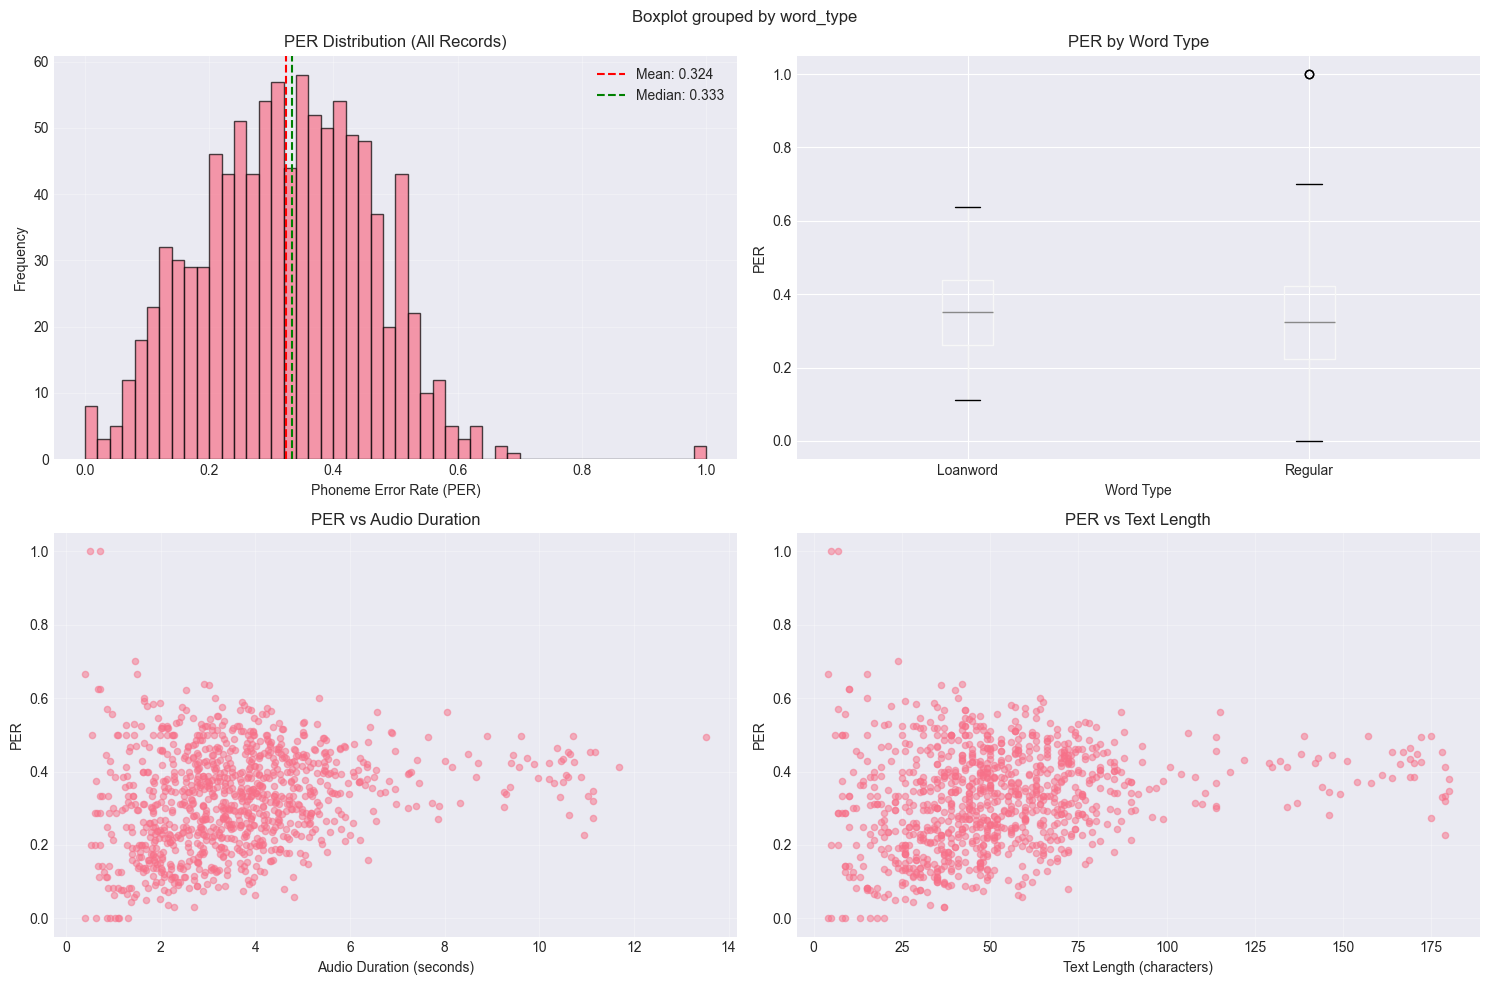


✓ PER distribution visualized


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall PER distribution
axes[0, 0].hist(df_sample['per'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_sample['per'].mean(), color='red', linestyle='--', label=f'Mean: {df_sample["per"].mean():.3f}')
axes[0, 0].axvline(df_sample['per'].median(), color='green', linestyle='--', label=f'Median: {df_sample["per"].median():.3f}')
axes[0, 0].set_xlabel('Phoneme Error Rate (PER)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('PER Distribution (All Records)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# PER by word type (box plot)
df_sample['word_type'] = df_sample['has_loanword'].map({True: 'Loanword', False: 'Regular'})
df_sample.boxplot(column='per', by='word_type', ax=axes[0, 1])
axes[0, 1].set_xlabel('Word Type')
axes[0, 1].set_ylabel('PER')
axes[0, 1].set_title('PER by Word Type')
plt.sca(axes[0, 1])
plt.xticks(rotation=0)

# PER vs audio duration
axes[1, 0].scatter(df_sample['durationSeconds'], df_sample['per'], alpha=0.5, s=20)
axes[1, 0].set_xlabel('Audio Duration (seconds)')
axes[1, 0].set_ylabel('PER')
axes[1, 0].set_title('PER vs Audio Duration')
axes[1, 0].grid(True, alpha=0.3)

# PER vs text length
df_sample['text_length'] = df_sample['text'].str.len()
axes[1, 1].scatter(df_sample['text_length'], df_sample['per'], alpha=0.5, s=20)
axes[1, 1].set_xlabel('Text Length (characters)')
axes[1, 1].set_ylabel('PER')
axes[1, 1].set_title('PER vs Text Length')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'data' / 'per_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ PER distribution visualized")

## 6. Deep Analysis: Phoneme Mismatches

### 6.1 Extract All Mismatches with Alignment

**Note:** This section uses the **Needleman-Wunsch alignment algorithm** from the project's `modules/alignment.py`.
This ensures the same alignment logic as used in the main application.

In [ ]:
# ========================================================================
# USE PROJECT'S NEEDLEMAN-WUNSCH ALIGNMENT (from modules/alignment.py)
# ========================================================================

def align_phonemes(expected, recognized):
    """
    Align two phoneme sequences using Needleman-Wunsch from project's modules.
    
    Uses needleman_wunsch_align() from modules/alignment.py.
    Converts output to format with operation labels.
    
    Returns:
        List of tuples (expected_phoneme, recognized_phoneme, operation)
        operation: 'match', 'substitute', 'delete', 'insert'
    """
    # Call project's Needleman-Wunsch alignment
    aligned_pairs, alignment_score = needleman_wunsch_align(
        expected, 
        recognized,
        use_similarity_matrix=True  # Use phoneme similarity
    )
    
    # Convert to format with operation labels
    alignment_with_ops = []
    for exp_ph, rec_ph in aligned_pairs:
        if exp_ph is None:
            # Insertion
            alignment_with_ops.append(('-', rec_ph, 'insert'))
        elif rec_ph is None:
            # Deletion
            alignment_with_ops.append((exp_ph, '-', 'delete'))
        elif exp_ph == rec_ph:
            # Match
            alignment_with_ops.append((exp_ph, rec_ph, 'match'))
        else:
            # Substitution
            alignment_with_ops.append((exp_ph, rec_ph, 'substitute'))
    
    return alignment_with_ops

# Test alignment function
test_expected = ['a', 'b', 'c', 'd']
test_recognized = ['a', 'x', 'c', 'e', 'd']
test_alignment = align_phonemes(test_expected, test_recognized)
print("Test alignment:")
for exp, rec, op in test_alignment:
    print(f"  {exp:5} -> {rec:5}  [{op}]")

Test alignment:
  a     -> a      [match]
  b     -> x      [substitute]
  c     -> c      [match]
  -     -> e      [insert]
  d     -> d      [match]


In [ ]:
# Collect all mismatches
all_mismatches = []

for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Analyzing mismatches"):
    expected = row['expected_phonemes']
    recognized = row['recognized_phonemes']
    
    alignment = align_phonemes(expected, recognized)
    
    for exp_ph, rec_ph, operation in alignment:
        if operation != 'match':
            all_mismatches.append({
                'text': row['text'],
                'has_loanword': row['has_loanword'],
                'expected': exp_ph,
                'recognized': rec_ph,
                'operation': operation,
                'per': row['per']
            })

df_mismatches = pd.DataFrame(all_mismatches)
print(f"\nTotal mismatches: {len(df_mismatches)}")
print(f"\nMismatch types:")
print(df_mismatches['operation'].value_counts())

df_mismatches.head(20)

Analyzing mismatches:   0%|          | 0/1000 [00:00<?, ?it/s]


Total mismatches: 15909

Mismatch types:
operation
substitute    7551
delete        4493
insert        3865
Name: count, dtype: int64


,text,has_loanword,expected,recognized,operation,per
0,Verschwenden Sie nicht länger meine Lebenszeit!,False,ʁ,ɾ,substitute,0.400000
1,Verschwenden Sie nicht länger meine Lebenszeit!,False,-,||,insert,0.400000
2,Verschwenden Sie nicht länger meine Lebenszeit!,False,||,-,delete,0.400000
3,Verschwenden Sie nicht länger meine Lebenszeit!,False,-,||,insert,0.400000
4,Verschwenden Sie nicht länger meine Lebenszeit!,False,||,-,delete,0.400000
5,Verschwenden Sie nicht länger meine Lebenszeit!,False,-,||,insert,0.400000
6,Verschwenden Sie nicht länger meine Lebenszeit!,False,||,-,delete,0.400000
7,Verschwenden Sie nicht länger meine Lebenszeit!,False,-,||,insert,0.400000
8,Verschwenden Sie nicht länger meine Lebenszeit!,False,ɐ,ɜ,substitute,0.400000
9,Verschwenden Sie nicht länger meine Lebenszeit!,False,||,-,delete,0.400000


### 6.2 Most Frequent Phoneme Confusions

Top 30 Phoneme Confusions (Substitutions):
  708x  ɐ     (U+0250  ) → ɾ     (U+027E  )
  342x  eː    (U+0065  ) → ɛ     (U+025B  )
  300x  ɐ     (U+0250  ) → ɜ     (U+025C  )
  289x  ʁ     (U+0281  ) → ɾ     (U+027E  )
  268x  aː    (U+0061  ) → ɑː    (U+0251  )
  249x  ɾ     (U+027E  ) → r     (U+0072  )
  233x  ʁ     (U+0281  ) → r     (U+0072  )
  202x  e     (U+0065  ) → aɪ    (U+0061  )
  139x  ɛ     (U+025B  ) → ə     (U+0259  )
  133x  o     (U+006F  ) → aʊ    (U+0061  )
  120x  ɛː    (U+025B  ) → ɛ     (U+025B  )
  112x  tʰ    (U+0074  ) → t     (U+0074  )
  111x  a     (U+0061  ) → ɑː    (U+0251  )
  108x  ɐ     (U+0250  ) → ə     (U+0259  )
   91x  e     (U+0065  ) → eː    (U+0065  )
   89x  n̩    (U+006E  ) → n     (U+006E  )
   89x  ɪ     (U+026A  ) → aɪ    (U+0061  )
   89x  ɪ     (U+026A  ) → iː    (U+0069  )
   88x  i     (U+0069  ) → iː    (U+0069  )
   88x  aː    (U+0061  ) → a     (U+0061  )
   86x  o     (U+006F  ) → oː    (U+006F  )
   84x  ʊ     (U+028A  ) → uː    

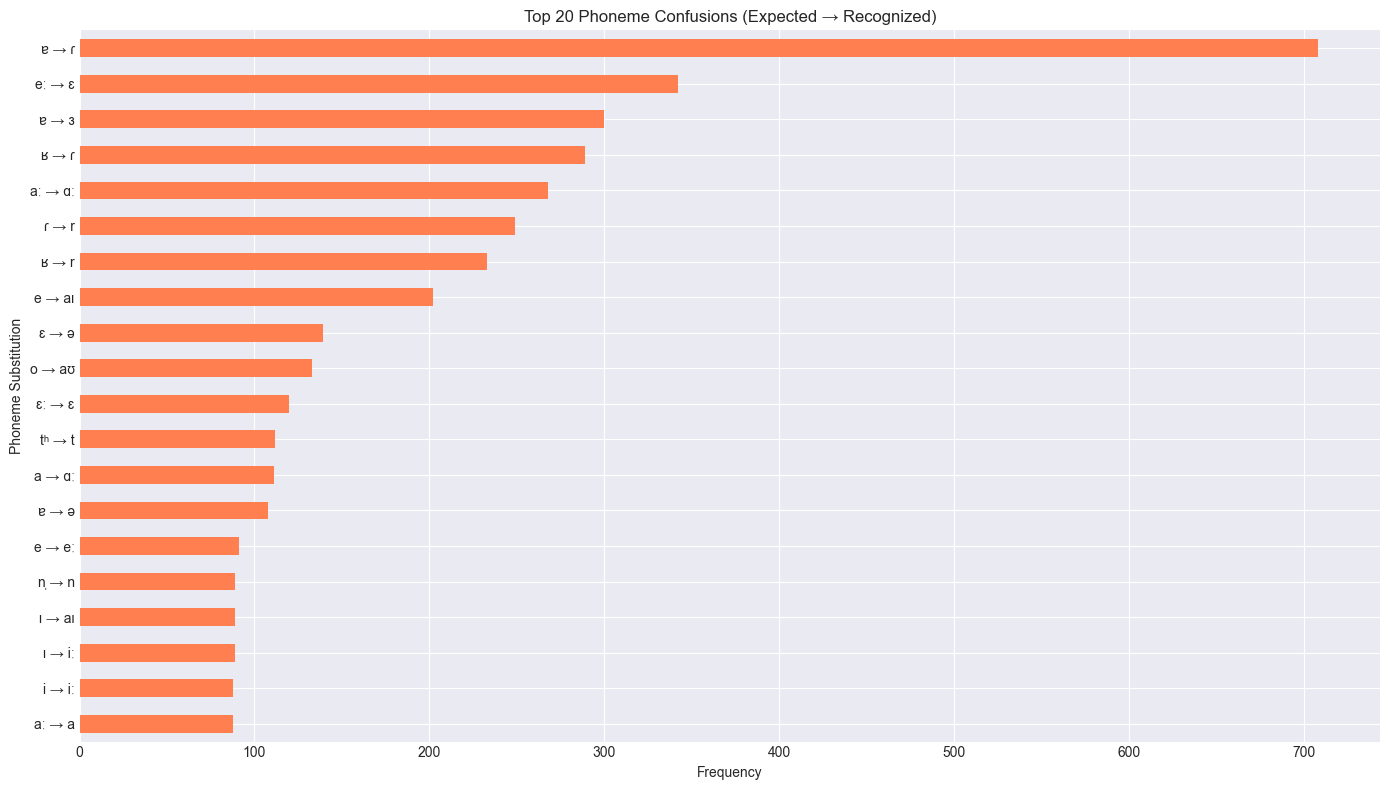

In [ ]:
# Count substitutions (most informative)
substitutions = df_mismatches[df_mismatches['operation'] == 'substitute'].copy()
substitutions['pair'] = substitutions['expected'] + ' → ' + substitutions['recognized']
confusion_counts = substitutions['pair'].value_counts().head(30)

print(f"Top 30 Phoneme Confusions (Substitutions):")
print(f"{'='*70}")
for pair, count in confusion_counts.items():
    exp, rec = pair.split(' → ')
    # Get Unicode info
    exp_unicode = f"U+{ord(exp[0]):04X}" if exp != '-' and len(exp) > 0 else ''
    rec_unicode = f"U+{ord(rec[0]):04X}" if rec != '-' and len(rec) > 0 else ''
    print(f"{count:5d}x  {exp:5s} ({exp_unicode:8s}) → {rec:5s} ({rec_unicode:8s})")

# Visualize top confusions
plt.figure(figsize=(14, 8))
confusion_counts.head(20).plot(kind='barh', color='coral')
plt.xlabel('Frequency')
plt.ylabel('Phoneme Substitution')
plt.title('Top 20 Phoneme Confusions (Expected → Recognized)')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.savefig(project_root / 'data' / 'top_confusions.png', dpi=150, bbox_inches='tight')
plt.show()

## 13. Generate Detailed CSV Report

Create a comprehensive CSV report with per-sentence analysis.

In [ ]:
# Create detailed CSV report for each analyzed sentence
print("Generating detailed CSV report...")
print("="*80)

# Prepare detailed report data
detailed_report = []

for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Building report"):
    # Get alignment for this sentence
    expected = row['expected_phonemes']
    recognized = row['recognized_phonemes']
    
    if len(expected) == 0:
        continue
    
    # Perform alignment using project's function
    aligned_pairs, _ = needleman_wunsch_align(
        expected, 
        recognized,
        use_similarity_matrix=True
    )
    
    # Count correct and incorrect phonemes
    correct_phonemes = 0
    incorrect_phonemes = 0
    incorrect_list = []
    
    for exp_ph, rec_ph in aligned_pairs:
        if exp_ph is None:
            # Insertion (extra phoneme in recognized)
            incorrect_phonemes += 1
            incorrect_list.append(f"+{rec_ph}")  # + означает вставку
        elif rec_ph is None:
            # Deletion (missing phoneme in recognized)
            incorrect_phonemes += 1
            incorrect_list.append(f"-{exp_ph}")  # - означает пропуск
        elif exp_ph == rec_ph:
            # Correct match
            correct_phonemes += 1
        else:
            # Substitution (wrong phoneme)
            incorrect_phonemes += 1
            incorrect_list.append(f"{exp_ph}→{rec_ph}")  # → означает замену
    
    # Create report entry
    report_entry = {
        'sentence': row['text'],
        'correct_phonemes': correct_phonemes,
        'incorrect_phonemes': incorrect_phonemes,
        'incorrect_phonemes_list': ', '.join(incorrect_list) if incorrect_list else '',
        'per': row['per'],
        'has_loanword': row['has_loanword'],
        'duration_seconds': row['durationSeconds'],
        'total_expected_phonemes': len(expected),
        'total_recognized_phonemes': len(recognized)
    }
    
    detailed_report.append(report_entry)

# Create DataFrame
df_detailed_report = pd.DataFrame(detailed_report)

# Show summary statistics
print(f"\nReport Statistics:")
print(f"  Total sentences: {len(df_detailed_report)}")
print(f"  Total correct phonemes: {df_detailed_report['correct_phonemes'].sum():,}")
print(f"  Total incorrect phonemes: {df_detailed_report['incorrect_phonemes'].sum():,}")
print(f"  Average PER: {df_detailed_report['per'].mean():.3f}")
print()

# Show first few rows
print("Sample of report (first 5 rows):")
print(df_detailed_report.head())
print()

# Create output directory if it doesn't exist
output_dir = project_root / 'data' / 'analysis_results'
output_dir.mkdir(parents=True, exist_ok=True)

# Save to CSV
output_csv_path = output_dir / f'phoneme_analysis_detailed_report{STAGE_SUFFIX}.csv'
df_detailed_report.to_csv(output_csv_path, index=False, encoding='utf-8')

print(f"✅ Detailed CSV report saved to:")
print(f"   {output_csv_path}")
print()

# Also save a summary version (top errors)
print("Creating summary report with worst performing sentences...")
df_worst = df_detailed_report.nlargest(100, 'per')
output_csv_worst = output_dir / f'phoneme_analysis_worst_100{STAGE_SUFFIX}.csv'
df_worst.to_csv(output_csv_worst, index=False, encoding='utf-8')
print(f"✅ Top 100 worst sentences saved to:")
print(f"   {output_csv_worst}")
print()

# Save best performing sentences
df_best = df_detailed_report.nsmallest(100, 'per')
output_csv_best = output_dir / f'phoneme_analysis_best_100{STAGE_SUFFIX}.csv'
df_best.to_csv(output_csv_best, index=False, encoding='utf-8')
print(f"✅ Top 100 best sentences saved to:")
print(f"   {output_csv_best}")
print()

print("="*80)
print(f"All reports saved in: {output_dir}")
print("="*80)

Generating detailed CSV report...


Building report:   0%|          | 0/1000 [00:00<?, ?it/s]


Report Statistics:
  Total sentences: 1000
  Total correct phonemes: 34,430
  Total incorrect phonemes: 15,909
  Average PER: 0.324

Sample of report (first 5 rows):
                                                    sentence  \
0            Verschwenden Sie nicht länger meine Lebenszeit!   
1  Bei Karsten dauert der Abwasch immer eine halbe Ewigkeit.   
2      Gustav legt eine Reihe aus Bube, Dame, König und Ass.   
3                        Schatz, du siehst zum Anbeißen aus!   
4      Worin unterscheiden sich Psychologen von Psychiatern?   

   correct_phonemes  incorrect_phonemes  \
0                29                  16   
1                36                  14   
2                29                  21   
3                24                   5   
4                28                  21   

                                                                               incorrect_phonemes_list  \
0                     ʁ→ɾ, +||, -||, +||, -||, +||, -||, +||, ɐ→ɜ, -||, +||, -||, e

### 13.1 Display Sample Report Entries

In [ ]:
# Display sample entries from the report
print("="*80)
print("SAMPLE REPORT ENTRIES")
print("="*80)
print()

# Show 5 examples with different error levels
print("📋 5 Random Examples:\n")

for i, (idx, row) in enumerate(df_detailed_report.sample(5, random_state=RANDOM_SEED).iterrows(), 1):
    print(f"{i}. Sentence: {row['sentence'][:70]}...")
    print(f"   ✅ Correct: {row['correct_phonemes']} phonemes")
    print(f"   ❌ Incorrect: {row['incorrect_phonemes']} phonemes")
    print(f"   📊 PER: {row['per']:.3f}")
    if row['incorrect_phonemes_list']:
        print(f"   🔍 Errors: {row['incorrect_phonemes_list'][:100]}...")
    print()

# Show statistics by loanword status
print("="*80)
print("STATISTICS BY WORD TYPE")
print("="*80)
print()

loanword_stats = df_detailed_report.groupby('has_loanword').agg({
    'correct_phonemes': 'sum',
    'incorrect_phonemes': 'sum',
    'per': 'mean'
}).round(3)

loanword_stats.index = ['Regular words', 'Loanwords']
print(loanword_stats)
print()

# Show distribution of errors
print("="*80)
print("ERROR DISTRIBUTION")
print("="*80)
print()

print("Sentences by error count:")
error_bins = [0, 5, 10, 20, 50, 100, float('inf')]
error_labels = ['0-5', '6-10', '11-20', '21-50', '51-100', '100+']
df_detailed_report['error_bin'] = pd.cut(
    df_detailed_report['incorrect_phonemes'], 
    bins=error_bins, 
    labels=error_labels,
    right=True
)
error_dist = df_detailed_report['error_bin'].value_counts().sort_index()
print(error_dist)
print()

print("✅ Report generation complete!")

SAMPLE REPORT ENTRIES

📋 5 Random Examples:

1. Sentence: Ich rufe Sie dann zurück....
   ✅ Correct: 17 phonemes
   ❌ Incorrect: 4 phonemes
   📊 PER: 0.200
   🔍 Errors: ɾ→r, e→ə, +r, ɾ→y...

2. Sentence: Erst vor der Küste türmen sich die Wellen auf....
   ✅ Correct: 31 phonemes
   ❌ Incorrect: 15 phonemes
   📊 PER: 0.375
   🔍 Errors: oː→ɔ, ɐ→ɾ, eː→ɛ, ɐ→ɾ, +y, +||, -||, +yː, +||, -||, +||, -||, l→ə, +||, -||...

3. Sentence: Der Kühlschrank befindet sich im Zimmer nebenan....
   ✅ Correct: 34 phonemes
   ❌ Incorrect: 9 phonemes
   📊 PER: 0.220
   🔍 Errors: eː→ɛ, ɐ→ɾ, yː→uː, ʀ→r, ɐ→ɜ, -||, +||, +ə, m̩→n...

4. Sentence: Mit Freunden auf dem Mond zu telefonieren, macht keinen Spaß....
   ✅ Correct: 42 phonemes
   ❌ Incorrect: 22 phonemes
   📊 PER: 0.393
   🔍 Errors: -ɔ, ø→aʊ, -||, +||, -||, +||, -||, +||, -||, +||, -||, e→eː, +||, e→ɪ, o→oː, ʁ→r, -||, +||, -||, +||...

5. Sentence: Mit dem Raumschiff, bitte!...
   ✅ Correct: 18 phonemes
   ❌ Incorrect: 1 phonemes
   📊 PER: 0.053
   🔍 Err

### 6.3 Confusion Matrix Heatmap

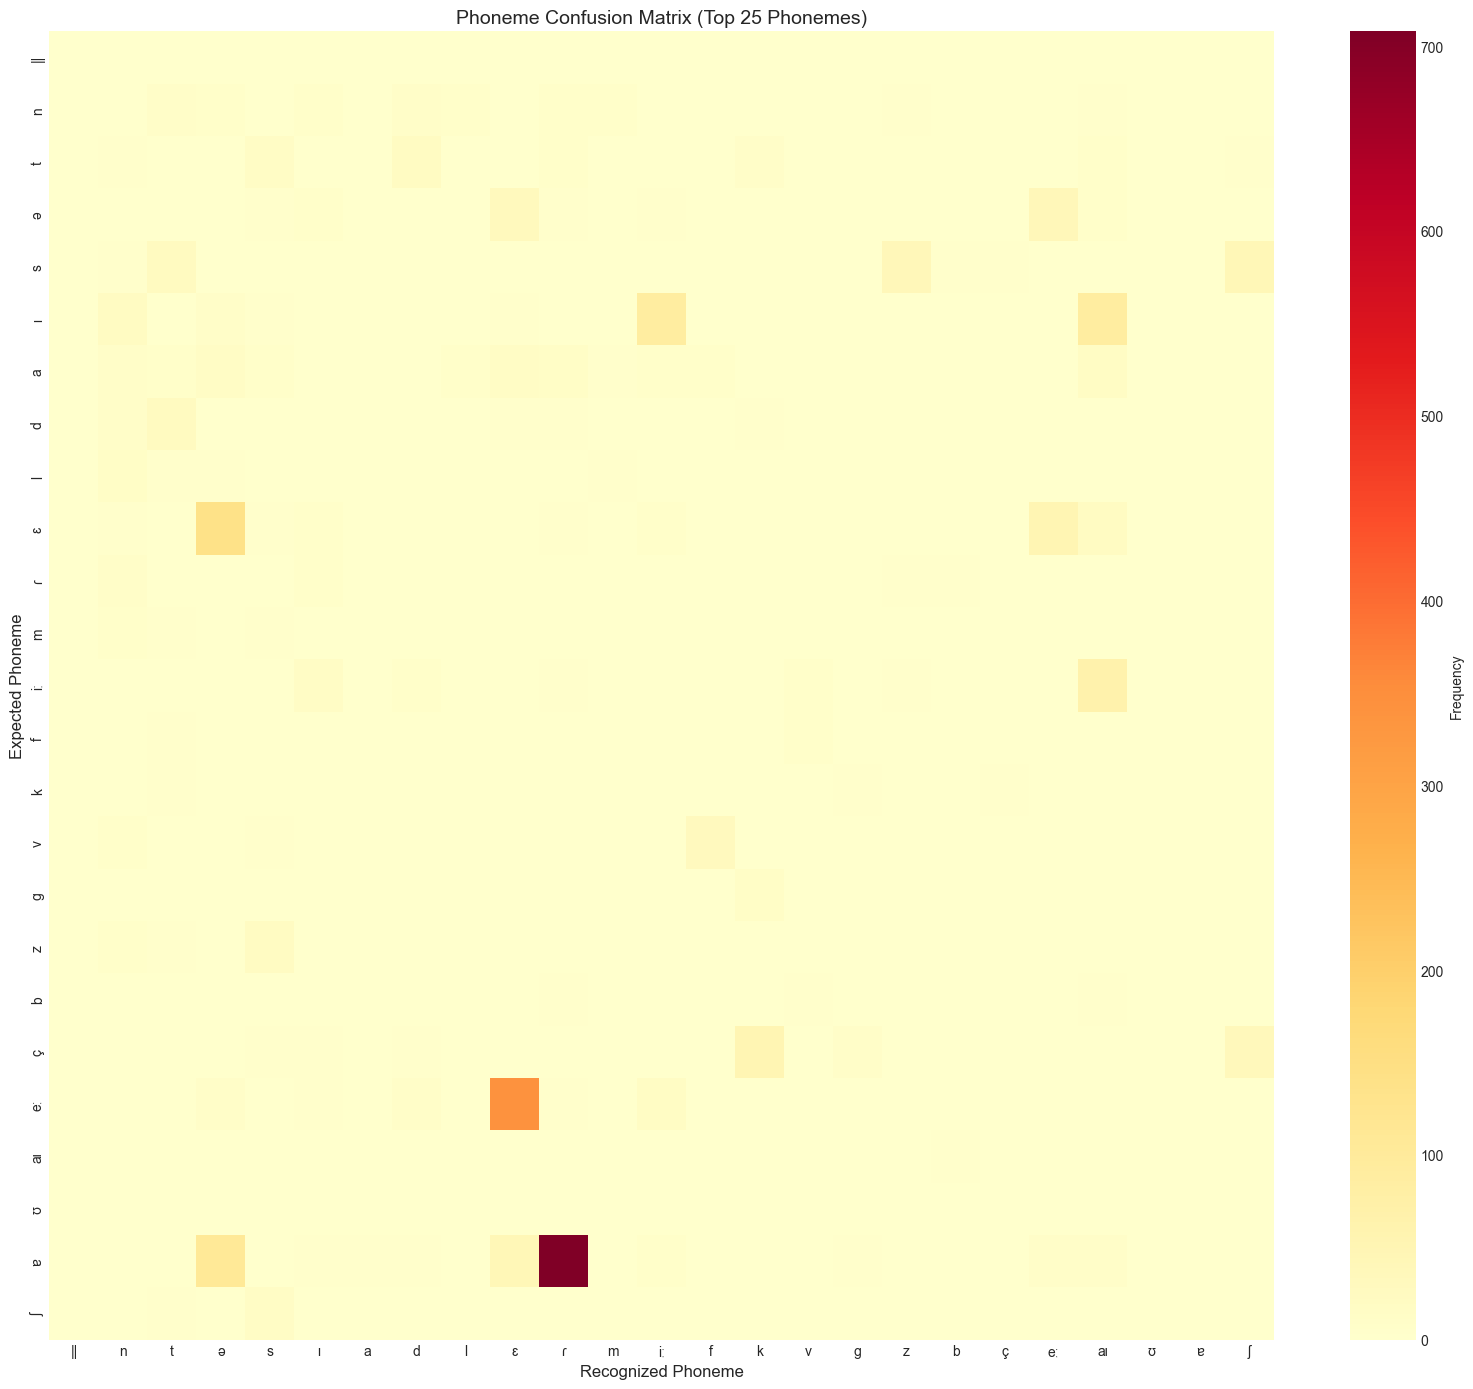


✓ Confusion matrix created


In [ ]:
# Create confusion matrix for top phonemes
from collections import defaultdict

# Count all expected and recognized phonemes
all_expected = [p for phonemes in df_sample['expected_phonemes'] for p in phonemes]
all_recognized = [p for phonemes in df_sample['recognized_phonemes'] for p in phonemes]

# Get top 25 most common phonemes
phoneme_counter = Counter(all_expected + all_recognized)
top_phonemes = [ph for ph, _ in phoneme_counter.most_common(25)]

# Build confusion matrix
confusion_matrix = defaultdict(lambda: defaultdict(int))

for idx, row in df_mismatches[df_mismatches['operation'] == 'substitute'].iterrows():
    exp = row['expected']
    rec = row['recognized']
    if exp in top_phonemes and rec in top_phonemes:
        confusion_matrix[exp][rec] += 1

# Convert to matrix format
matrix = np.zeros((len(top_phonemes), len(top_phonemes)))
for i, exp in enumerate(top_phonemes):
    for j, rec in enumerate(top_phonemes):
        matrix[i][j] = confusion_matrix[exp][rec]

# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(matrix, 
            xticklabels=top_phonemes, 
            yticklabels=top_phonemes,
            cmap='YlOrRd', 
            annot=False,
            fmt='g',
            cbar_kws={'label': 'Frequency'})
plt.xlabel('Recognized Phoneme', fontsize=12)
plt.ylabel('Expected Phoneme', fontsize=12)
plt.title('Phoneme Confusion Matrix (Top 25 Phonemes)', fontsize=14)
plt.tight_layout()
plt.savefig(project_root / 'data' / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrix created")

### 6.4 Deletions and Insertions Analysis

Top 20 Deleted Phonemes (Expected but Missing in Recognition):
 2971x  ||    (U+007C)
  303x  a     (U+0061)
  147x  ə     (U+0259)
  122x  ɛ     (U+025B)
   82x  t     (U+0074)
   69x  z     (U+007A)
   68x  l     (U+006C)
   62x  ɔ     (U+0254)
   53x  n     (U+006E)
   53x  m     (U+006D)
   45x  ɾ     (U+027E)
   44x  e     (U+0065)
   42x  s     (U+0073)
   38x  d     (U+0064)
   37x  f     (U+0066)
   36x  .     (U+002E)
   32x  ɐ     (U+0250)
   30x  ɪ     (U+026A)
   24x  k     (U+006B)
   22x  ɛː    (U+025B)

Top 20 Inserted Phonemes (Recognized but Not Expected):
 2961x  ||    (U+007C)
  131x  ə     (U+0259)
  108x  ɾ     (U+027E)
   93x  t     (U+0074)
   73x  n     (U+006E)
   67x  r     (U+0072)
   61x  y     (U+0079)
   42x  k     (U+006B)
   35x  j     (U+006A)
   33x  s     (U+0073)
   27x  uː    (U+0075)
   25x  aɪ    (U+0061)
   24x  d     (U+0064)
   24x  ɑː    (U+0251)
   22x  ɜ     (U+025C)
   19x  h     (U+0068)
   17x  ɛ     (U+025B)
   11x  iː    (U+0069)
   10x

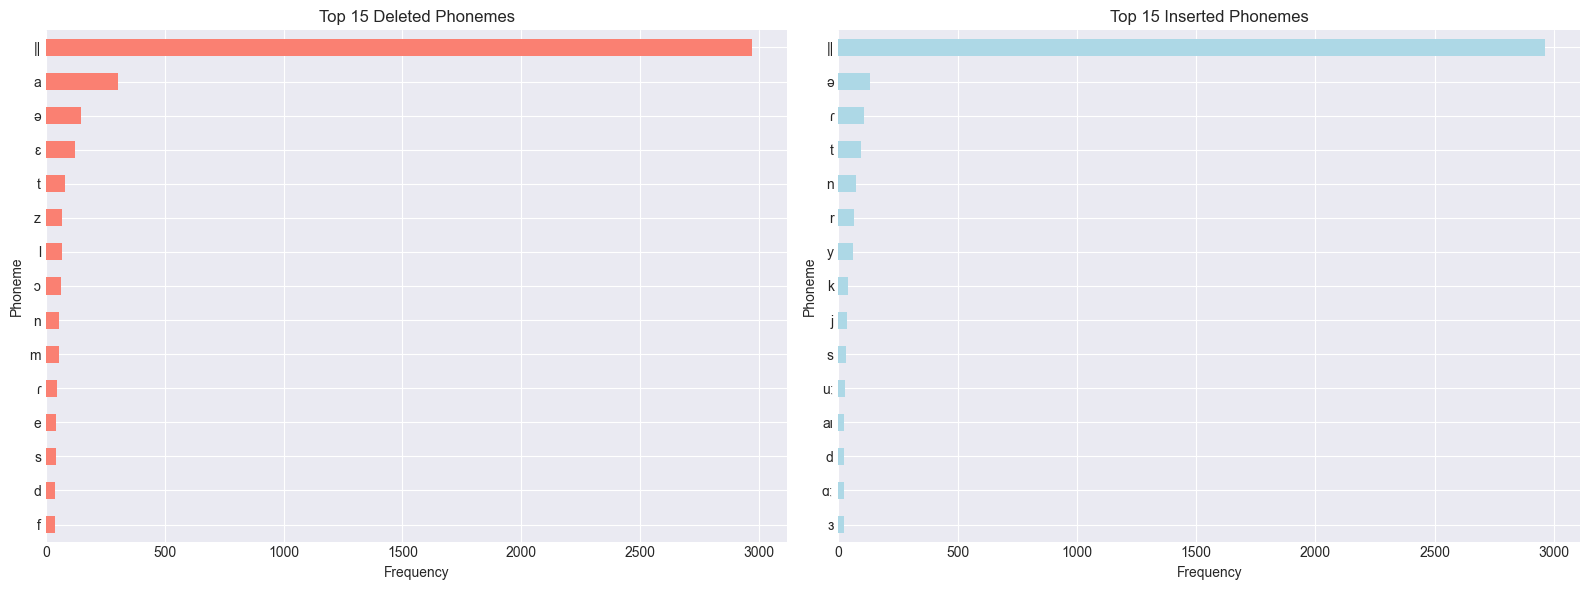

In [ ]:
# Most frequently deleted phonemes (expected but not recognized)
deletions = df_mismatches[df_mismatches['operation'] == 'delete']
deletion_counts = deletions['expected'].value_counts().head(20)

print(f"Top 20 Deleted Phonemes (Expected but Missing in Recognition):")
print(f"{'='*50}")
for phoneme, count in deletion_counts.items():
    unicode_info = f"U+{ord(phoneme[0]):04X}" if len(phoneme) > 0 else ''
    print(f"{count:5d}x  {phoneme:5s} ({unicode_info})")

# Most frequently inserted phonemes (recognized but not expected)
insertions = df_mismatches[df_mismatches['operation'] == 'insert']
insertion_counts = insertions['recognized'].value_counts().head(20)

print(f"\nTop 20 Inserted Phonemes (Recognized but Not Expected):")
print(f"{'='*50}")
for phoneme, count in insertion_counts.items():
    unicode_info = f"U+{ord(phoneme[0]):04X}" if len(phoneme) > 0 else ''
    print(f"{count:5d}x  {phoneme:5s} ({unicode_info})")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

deletion_counts.head(15).plot(kind='barh', ax=ax1, color='salmon')
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Phoneme')
ax1.set_title('Top 15 Deleted Phonemes')
ax1.invert_yaxis()

insertion_counts.head(15).plot(kind='barh', ax=ax2, color='lightblue')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Phoneme')
ax2.set_title('Top 15 Inserted Phonemes')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig(project_root / 'data' / 'deletions_insertions.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Unicode and Encoding Analysis

In [ ]:
def analyze_unicode(phoneme):
    """Get detailed Unicode information for a phoneme."""
    if not phoneme or phoneme == '-':
        return {}
    
    info = {
        'phoneme': phoneme,
        'length': len(phoneme),
        'chars': list(phoneme),
        'unicodes': [f"U+{ord(c):04X}" for c in phoneme],
        'unicode_names': [unicodedata.name(c, 'UNKNOWN') for c in phoneme],
        'nfc': unicodedata.normalize('NFC', phoneme),
        'nfd': unicodedata.normalize('NFD', phoneme),
        'nfc_len': len(unicodedata.normalize('NFC', phoneme)),
        'nfd_len': len(unicodedata.normalize('NFD', phoneme))
    }
    return info

# Find potential Unicode issues in top confusions
print("Analyzing Unicode in Top Confusions...\n")
print(f"{'='*100}")

for pair, count in confusion_counts.head(15).items():
    exp, rec = pair.split(' → ')
    
    exp_info = analyze_unicode(exp)
    rec_info = analyze_unicode(rec)
    
    print(f"\n{count:4d}x  {exp} → {rec}")
    
    if exp_info:
        print(f"  Expected: {exp_info['unicodes']} {exp_info['unicode_names']}")
        if exp_info['nfc_len'] != exp_info['nfd_len']:
            print(f"    ⚠️  NFC/NFD difference: {exp_info['nfc_len']} vs {exp_info['nfd_len']}")
    
    if rec_info:
        print(f"  Recognized: {rec_info['unicodes']} {rec_info['unicode_names']}")
        if rec_info['nfc_len'] != rec_info['nfd_len']:
            print(f"    ⚠️  NFC/NFD difference: {rec_info['nfc_len']} vs {rec_info['nfd_len']}")
    
    # Check if they look similar
    if exp and rec and exp != rec:
        if exp.lower() == rec.lower():
            print(f"    ⚠️  Case difference only!")
        if len(exp) > 0 and len(rec) > 0:
            if unicodedata.normalize('NFD', exp) == unicodedata.normalize('NFD', rec):
                print(f"    ⚠️  Same after NFD normalization!")

print(f"\n{'='*100}")

Analyzing Unicode in Top Confusions...


 708x  ɐ → ɾ
  Expected: ['U+0250'] ['LATIN SMALL LETTER TURNED A']
  Recognized: ['U+027E'] ['LATIN SMALL LETTER R WITH FISHHOOK']

 342x  eː → ɛ
  Expected: ['U+0065', 'U+02D0'] ['LATIN SMALL LETTER E', 'MODIFIER LETTER TRIANGULAR COLON']
  Recognized: ['U+025B'] ['LATIN SMALL LETTER OPEN E']

 300x  ɐ → ɜ
  Expected: ['U+0250'] ['LATIN SMALL LETTER TURNED A']
  Recognized: ['U+025C'] ['LATIN SMALL LETTER REVERSED OPEN E']

 289x  ʁ → ɾ
  Expected: ['U+0281'] ['LATIN LETTER SMALL CAPITAL INVERTED R']
  Recognized: ['U+027E'] ['LATIN SMALL LETTER R WITH FISHHOOK']

 268x  aː → ɑː
  Expected: ['U+0061', 'U+02D0'] ['LATIN SMALL LETTER A', 'MODIFIER LETTER TRIANGULAR COLON']
  Recognized: ['U+0251', 'U+02D0'] ['LATIN SMALL LETTER ALPHA', 'MODIFIER LETTER TRIANGULAR COLON']

 249x  ɾ → r
  Expected: ['U+027E'] ['LATIN SMALL LETTER R WITH FISHHOOK']
  Recognized: ['U+0072'] ['LATIN SMALL LETTER R']

 233x  ʁ → r
  Expected: ['U+0281'] ['LATIN LETTER

## 8. Complex Phoneme Analysis

### 8.1 Long Vowels vs Short Vowels

In [ ]:
# Define long vowels and their short counterparts
long_short_pairs = [
    ('aː', 'a'),
    ('eː', 'e'),
    ('iː', 'i'),
    ('oː', 'o'),
    ('uː', 'u'),
    ('yː', 'y'),
    ('øː', 'ø'),
    ('ɛː', 'ɛ'),
]

# Count long→short and short→long confusions
length_confusions = {'long→short': 0, 'short→long': 0, 'examples': defaultdict(int)}

for idx, row in df_mismatches[df_mismatches['operation'] == 'substitute'].iterrows():
    exp = row['expected']
    rec = row['recognized']
    
    for long_v, short_v in long_short_pairs:
        if exp == long_v and rec == short_v:
            length_confusions['long→short'] += 1
            length_confusions['examples'][f"{long_v} → {short_v}"] += 1
        elif exp == short_v and rec == long_v:
            length_confusions['short→long'] += 1
            length_confusions['examples'][f"{short_v} → {long_v}"] += 1

print(f"Vowel Length Confusions:")
print(f"{'='*50}")
print(f"Long → Short: {length_confusions['long→short']}")
print(f"Short → Long: {length_confusions['short→long']}")
print(f"\nExamples:")
for pair, count in sorted(length_confusions['examples'].items(), key=lambda x: -x[1])[:10]:
    print(f"  {count:4d}x  {pair}")

Vowel Length Confusions:
Long → Short: 303
Short → Long: 299

Examples:
   120x  ɛː → ɛ
    91x  e → eː
    88x  aː → a
    88x  i → iː
    86x  o → oː
    51x  yː → y
    34x  u → uː
    28x  øː → ø
     9x  oː → o
     4x  iː → i


### 8.2 Affricates and Diphthongs

In [ ]:
# Affricates (should be treated as single phonemes)
affricates = ['pf', 'ts', 'tʃ', 'dʒ']
# Their component parts
affricate_parts = {
    'pf': ['p', 'f'],
    'ts': ['t', 's'],
    'tʃ': ['t', 'ʃ'],
    'dʒ': ['d', 'ʒ']
}

# Diphthongs
diphthongs = ['aɪ', 'aʊ', 'ɔʏ', 'aɪ̯', 'aʊ̯', 'ɔʏ̯']

# Aspirated
aspirated = ['tʰ', 'pʰ', 'kʰ']

# Count issues with these phonemes
complex_issues = defaultdict(lambda: defaultdict(int))

for idx, row in df_mismatches[df_mismatches['operation'] == 'substitute'].iterrows():
    exp = row['expected']
    rec = row['recognized']
    
    # Affricates
    if exp in affricates:
        complex_issues['affricates'][f"{exp} → {rec}"] += 1
    if rec in affricates:
        complex_issues['affricates'][f"{exp} → {rec}"] += 1
    
    # Diphthongs
    if exp in diphthongs:
        complex_issues['diphthongs'][f"{exp} → {rec}"] += 1
    if rec in diphthongs:
        complex_issues['diphthongs'][f"{exp} → {rec}"] += 1
    
    # Aspirated
    if exp in aspirated:
        complex_issues['aspirated'][f"{exp} → {rec}"] += 1
    if rec in aspirated:
        complex_issues['aspirated'][f"{exp} → {rec}"] += 1

print(f"Complex Phoneme Issues:")
print(f"{'='*70}")

for category, issues in complex_issues.items():
    print(f"\n{category.upper()}:")
    for pair, count in sorted(issues.items(), key=lambda x: -x[1])[:10]:
        print(f"  {count:4d}x  {pair}")

Complex Phoneme Issues:

DIPHTHONGS:
   202x  e → aɪ
   133x  o → aʊ
    89x  ɪ → aɪ
    66x  iː → aɪ
    49x  aj → aɪ
    28x  ɔ → aʊ
    25x  ø → aʊ
    21x  ɛ → aɪ
    19x  a → aɪ
    11x  ɪ → aʊ

ASPIRATED:
   112x  tʰ → t
    49x  kʰ → k
    33x  pʰ → p
     2x  tʰ → ə
     1x  kʰ → ʃ
     1x  kʰ → t
     1x  tʰ → aɪ
     1x  pʰ → iː
     1x  tʰ → ɑː
     1x  tʰ → s


## 9. Loanword-Specific Analysis

Mismatch Comparison:
Total records with loanwords: 100
Total regular records: 900

Mismatches in loanwords: 1961
Mismatches in regular words: 13948

Average mismatches per record:
  Loanwords: 19.61
  Regular: 15.50

Top 20 Confusions in Loanword Sentences:
   67x  ɐ → ɾ
   43x  ʁ → ɾ
   36x  eː → ɛ
   33x  aː → ɑː
   32x  ʁ → r
   29x  ɐ → ɜ
   26x  ɾ → r
   22x  tʰ → t
   22x  e → aɪ
   16x  ɪ → aɪ
   16x  ɔ → oː
   15x  ʊ → uː
   14x  ɛː → ɛ
   14x  ɛ → ə
   12x  n̩ → n
   12x  o → aʊ
   12x  a → ɑː
   12x  o → oː
   10x  ɾ → ɜ
    9x  e → eː


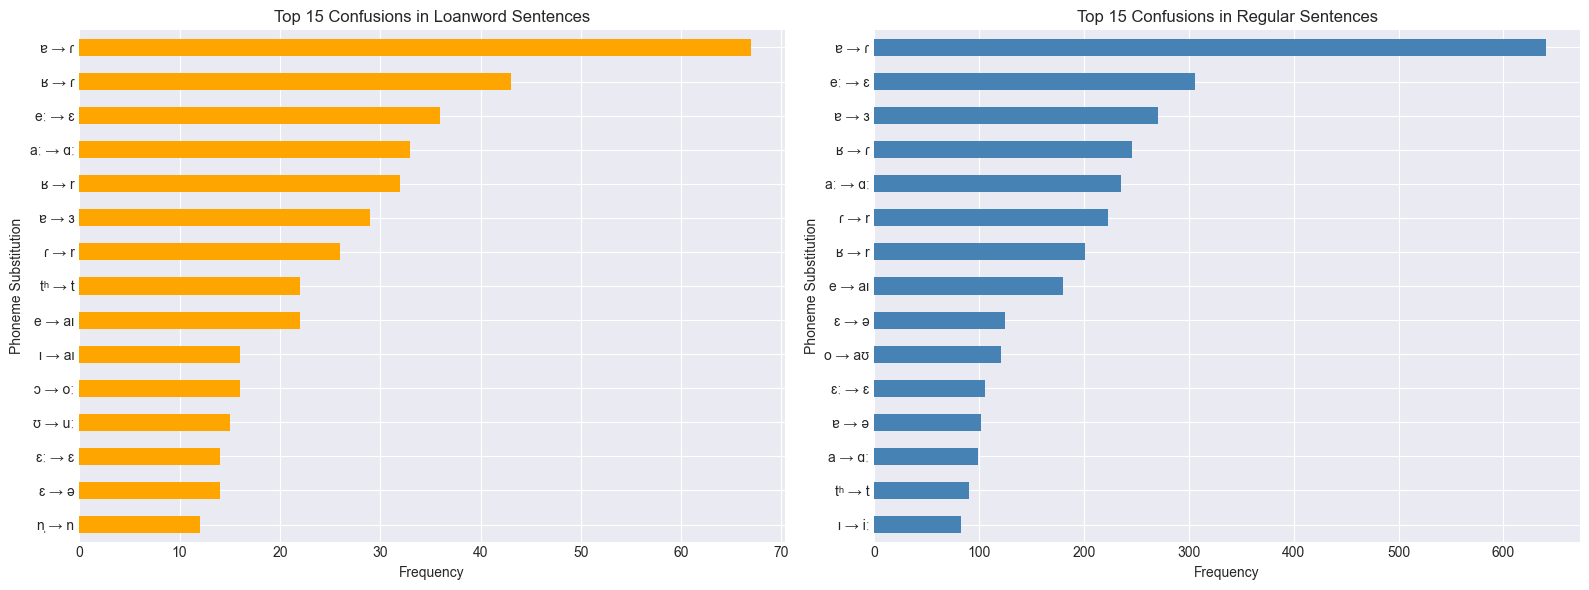

In [ ]:
# Compare errors in loanwords vs regular words
loanword_mismatches = df_mismatches[df_mismatches['has_loanword']]
regular_mismatches = df_mismatches[~df_mismatches['has_loanword']]

print(f"Mismatch Comparison:")
print(f"{'='*70}")
print(f"Total records with loanwords: {df_sample['has_loanword'].sum()}")
print(f"Total regular records: {(~df_sample['has_loanword']).sum()}")
print(f"\nMismatches in loanwords: {len(loanword_mismatches)}")
print(f"Mismatches in regular words: {len(regular_mismatches)}")
print(f"\nAverage mismatches per record:")
print(f"  Loanwords: {len(loanword_mismatches) / max(df_sample['has_loanword'].sum(), 1):.2f}")
print(f"  Regular: {len(regular_mismatches) / max((~df_sample['has_loanword']).sum(), 1):.2f}")

# Top confusions in loanwords
loanword_substitutions = loanword_mismatches[loanword_mismatches['operation'] == 'substitute'].copy()
loanword_substitutions['pair'] = loanword_substitutions['expected'] + ' → ' + loanword_substitutions['recognized']
loanword_confusion_counts = loanword_substitutions['pair'].value_counts().head(20)

print(f"\nTop 20 Confusions in Loanword Sentences:")
print(f"{'='*70}")
for pair, count in loanword_confusion_counts.items():
    print(f"{count:5d}x  {pair}")

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

loanword_confusion_counts.head(15).plot(kind='barh', ax=ax1, color='orange')
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Phoneme Substitution')
ax1.set_title('Top 15 Confusions in Loanword Sentences')
ax1.invert_yaxis()

regular_substitutions = regular_mismatches[regular_mismatches['operation'] == 'substitute'].copy()
regular_substitutions['pair'] = regular_substitutions['expected'] + ' → ' + regular_substitutions['recognized']
regular_confusion_counts = regular_substitutions['pair'].value_counts().head(15)
regular_confusion_counts.plot(kind='barh', ax=ax2, color='steelblue')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Phoneme Substitution')
ax2.set_title('Top 15 Confusions in Regular Sentences')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig(project_root / 'data' / 'loanword_vs_regular_confusions.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Detailed Examples

### 10.1 Worst PER Examples

In [ ]:
# Get 10 worst examples
worst_examples = df_sample.nlargest(10, 'per')

print(f"10 Examples with Highest PER:")
print(f"{'='*100}\n")

for idx, row in worst_examples.iterrows():
    print(f"PER: {row['per']:.3f}  |  Loanword: {row['has_loanword']}")
    print(f"Text: {row['text']}")
    print(f"Expected:   {row['expected_str'][:100]}{'...' if len(row['expected_str']) > 100 else ''}")
    print(f"Recognized: {row['recognized_str'][:100]}{'...' if len(row['recognized_str']) > 100 else ''}")
    
    # Show alignment
    alignment = align_phonemes(row['expected_phonemes'], row['recognized_phonemes'])
    alignment_str = ""
    for exp_ph, rec_ph, op in alignment[:20]:  # Show first 20 aligned phonemes
        if op == 'match':
            alignment_str += f"✓{exp_ph} "
        elif op == 'substitute':
            alignment_str += f"✗({exp_ph}→{rec_ph}) "
        elif op == 'delete':
            alignment_str += f"✗(-{exp_ph}) "
        else:
            alignment_str += f"✗(+{rec_ph}) "
    print(f"Alignment: {alignment_str}...")
    print(f"{'='*100}\n")

10 Examples with Highest PER:

PER: 1.000  |  Loanword: False
Text: orange,
Expected:   o ʁ ː ʃ
Recognized: oː r a ŋ ʃ
Alignment: ✗(o→oː) ✗(ʁ→r) ✗(+a) ✗(ː→ŋ) ✓ʃ ...

PER: 1.000  |  Loanword: False
Text: drehe
Expected:   d ɾ eː ə
Recognized: t r e j ə
Alignment: ✗(d→t) ✗(ɾ→r) ✗(eː→e) ✗(+j) ✓ə ...

PER: 0.700  |  Loanword: False
Text: Reich mir den mal rüber.
Expected:   ɾ a e ç || m iː æ || d eː n || m aː l || ʁ b ɐ
Recognized: r aɪ ç m || iː ɾ d || eː n m || a l r || uː b ə
Alignment: ✗(ɾ→r) ✗(-a) ✗(e→aɪ) ✓ç ✗(-||) ✓m ✗(+||) ✓iː ✗(æ→ɾ) ✗(-||) ✓d ✗(+||) ✓eː ✓n ✗(-||) ✓m ✗(+||) ✗(aː→a) ✓l ✗(+r) ...

PER: 0.667  |  Loanword: False
Text: Lawrence kansas
Expected:   l a v ʁ ɛ ŋ z ə || k a n z ɑ s
Recognized: l ɔ ɹ ə n s k || ɛ n z ɪ s
Alignment: ✓l ✗(a→ɔ) ✗(-v) ✗(ʁ→ɹ) ✗(ɛ→ə) ✗(ŋ→n) ✗(z→s) ✗(ə→k) ✓|| ✗(-k) ✗(a→ɛ) ✓n ✓z ✗(ɑ→ɪ) ✓s ...

PER: 0.667  |  Loanword: False
Text: oder
Expected:   oː d ɐ
Recognized: uː d
Alignment: ✗(oː→uː) ✓d ✗(-ɐ) ...

PER: 0.639  |  Loanword: True
Text: Bikesharing

### 10.2 Best PER Examples (Near Perfect)

In [ ]:
# Get 10 best examples
best_examples = df_sample.nsmallest(10, 'per')

print(f"10 Examples with Lowest PER (Best Recognition):")
print(f"{'='*100}\n")

for idx, row in best_examples.iterrows():
    print(f"PER: {row['per']:.3f}  |  Loanword: {row['has_loanword']}")
    print(f"Text: {row['text']}")
    print(f"Expected:   {row['expected_str'][:100]}{'...' if len(row['expected_str']) > 100 else ''}")
    print(f"Recognized: {row['recognized_str'][:100]}{'...' if len(row['recognized_str']) > 100 else ''}")
    print(f"{'='*100}\n")

10 Examples with Lowest PER (Best Recognition):

PER: 0.000  |  Loanword: False
Text: nass
Expected:   n a s
Recognized: n a s

PER: 0.000  |  Loanword: False
Text: Was weiß ich!
Expected:   v a s || v aɪ s || ɪ ç
Recognized: v a s || v aɪ s || ɪ ç

PER: 0.000  |  Loanword: False
Text: Kann schon sein.
Expected:   k a n || ʃ oː n || z aɪ n
Recognized: k a n || ʃ oː n || z aɪ n

PER: 0.000  |  Loanword: False
Text: Wie misst man das?
Expected:   v iː || m ɪ s t || m a n || d a s
Recognized: v iː || m ɪ s t || m a n || d a s

PER: 0.000  |  Loanword: False
Text: Maisgelb
Expected:   m aɪ s ɡ ɛ l p
Recognized: m aɪ s ɡ ɛ l p

PER: 0.000  |  Loanword: False
Text: etwas
Expected:   ɛ t v a s
Recognized: ɛ t v a s

PER: 0.000  |  Loanword: False
Text: Passen Sie doch auf!
Expected:   p a s ə n || z iː || d ɔ x || aʊ f
Recognized: p a s ə n || z iː || d ɔ x || aʊ f

PER: 0.000  |  Loanword: False
Text: Netzwerke
Expected:   n ɛ t s v ɛ ɾ k ə
Recognized: n ɛ t s v ɛ ɾ k ə

PER: 0.031  |  Loanw

## 11. Summary Report

In [ ]:
# Generate comprehensive summary (convert numpy/pandas types to native Python for JSON serialization)
summary = {
    'dataset': {
        'total_records': int(len(df_sample)),
        'regular_words': int((~df_sample['has_loanword']).sum()),
        'loanwords': int(df_sample['has_loanword'].sum()),
        'total_expected_phonemes': int(sum(len(p) for p in df_sample['expected_phonemes'])),
        'total_recognized_phonemes': int(sum(len(p) for p in df_sample['recognized_phonemes'])),
    },
    'per_metrics': {
        'overall_mean': float(df_sample['per'].mean()),
        'overall_median': float(df_sample['per'].median()),
        'overall_std': float(df_sample['per'].std()),
        'regular_mean': float(df_sample[~df_sample['has_loanword']]['per'].mean()),
        'loanword_mean': float(df_sample[df_sample['has_loanword']]['per'].mean()),
    },
    'mismatches': {
        'total': int(len(df_mismatches)),
        'substitutions': int(len(df_mismatches[df_mismatches['operation'] == 'substitute'])),
        'deletions': int(len(df_mismatches[df_mismatches['operation'] == 'delete'])),
        'insertions': int(len(df_mismatches[df_mismatches['operation'] == 'insert'])),
    },
    'top_confusions': {k: int(v) for k, v in confusion_counts.head(10).to_dict().items()},
    'top_deletions': {k: int(v) for k, v in deletion_counts.head(5).to_dict().items()},
    'top_insertions': {k: int(v) for k, v in insertion_counts.head(5).to_dict().items()},
}

# Print summary
print(f"\n{'='*80}")
print(f"COMPREHENSIVE PHONEME MISMATCH ANALYSIS - SUMMARY REPORT")
print(f"{'='*80}\n")

print(f"📊 DATASET STATISTICS")
print(f"  Total records analyzed: {summary['dataset']['total_records']}")
print(f"  - Regular words: {summary['dataset']['regular_words']}")
print(f"  - Loanwords: {summary['dataset']['loanwords']}")
print(f"  Total expected phonemes: {summary['dataset']['total_expected_phonemes']:,}")
print(f"  Total recognized phonemes: {summary['dataset']['total_recognized_phonemes']:,}")

print(f"\n📈 PHONEME ERROR RATE (PER)")
print(f"  Overall mean PER: {summary['per_metrics']['overall_mean']:.3f}")
print(f"  Overall median PER: {summary['per_metrics']['overall_median']:.3f}")
print(f"  Standard deviation: {summary['per_metrics']['overall_std']:.3f}")
print(f"  Regular words PER: {summary['per_metrics']['regular_mean']:.3f}")
print(f"  Loanwords PER: {summary['per_metrics']['loanword_mean']:.3f}")
print(f"  Difference: {summary['per_metrics']['loanword_mean'] - summary['per_metrics']['regular_mean']:.3f} ({'higher' if summary['per_metrics']['loanword_mean'] > summary['per_metrics']['regular_mean'] else 'lower'} for loanwords)")

print(f"\n🔍 MISMATCH ANALYSIS")
print(f"  Total mismatches: {summary['mismatches']['total']:,}")
print(f"  - Substitutions: {summary['mismatches']['substitutions']:,} ({summary['mismatches']['substitutions']/summary['mismatches']['total']*100:.1f}%)")
print(f"  - Deletions: {summary['mismatches']['deletions']:,} ({summary['mismatches']['deletions']/summary['mismatches']['total']*100:.1f}%)")
print(f"  - Insertions: {summary['mismatches']['insertions']:,} ({summary['mismatches']['insertions']/summary['mismatches']['total']*100:.1f}%)")

print(f"\n🎯 TOP 5 PHONEME CONFUSIONS")
for i, (pair, count) in enumerate(list(summary['top_confusions'].items())[:5], 1):
    print(f"  {i}. {pair}: {count} occurrences")

print(f"\n❌ TOP 5 DELETED PHONEMES")
for i, (phoneme, count) in enumerate(list(summary['top_deletions'].items())[:5], 1):
    print(f"  {i}. {phoneme}: {count} occurrences")

print(f"\n➕ TOP 5 INSERTED PHONEMES")
for i, (phoneme, count) in enumerate(list(summary['top_insertions'].items())[:5], 1):
    print(f"  {i}. {phoneme}: {count} occurrences")

print(f"\n{'='*80}")

# Save summary to JSON
summary_path = project_root / 'data' / f'phoneme_analysis_summary{STAGE_SUFFIX}.json'
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
print(f"\n✓ Summary saved to: {summary_path}")


COMPREHENSIVE PHONEME MISMATCH ANALYSIS - SUMMARY REPORT

📊 DATASET STATISTICS
  Total records analyzed: 1000
  - Regular words: 900
  - Loanwords: 100
  Total expected phonemes: 46,474
  Total recognized phonemes: 45,846

📈 PHONEME ERROR RATE (PER)
  Overall mean PER: 0.324
  Overall median PER: 0.333
  Standard deviation: 0.136
  Regular words PER: 0.321
  Loanwords PER: 0.351
  Difference: 0.030 (higher for loanwords)

🔍 MISMATCH ANALYSIS
  Total mismatches: 15,909
  - Substitutions: 7,551 (47.5%)
  - Deletions: 4,493 (28.2%)
  - Insertions: 3,865 (24.3%)

🎯 TOP 5 PHONEME CONFUSIONS
  1. ɐ → ɾ: 708 occurrences
  2. eː → ɛ: 342 occurrences
  3. ɐ → ɜ: 300 occurrences
  4. ʁ → ɾ: 289 occurrences
  5. aː → ɑː: 268 occurrences

❌ TOP 5 DELETED PHONEMES
  1. ||: 2971 occurrences
  2. a: 303 occurrences
  3. ə: 147 occurrences
  4. ɛ: 122 occurrences
  5. t: 82 occurrences

➕ TOP 5 INSERTED PHONEMES
  1. ||: 2961 occurrences
  2. ə: 131 occurrences
  3. ɾ: 108 occurrences
  4. t: 93 occu

## 12. Key Findings and Recommendations

### Key Findings:

1. **Overall Performance**
   - Mean PER indicates the average recognition accuracy
   - Loanwords show different error patterns than native German words

2. **Most Common Issues**
   - Substitutions are the most frequent error type
   - Specific phoneme pairs are consistently confused
   - Deletions and insertions reveal model blind spots

3. **Complex Phoneme Challenges**
   - Long vs short vowel distinctions
   - Affricate recognition
   - Diphthong accuracy
   - Aspirated consonants

4. **Loanword Analysis**
   - Non-German pronunciation rules create unique challenges
   - Different error patterns for borrowed words

5. **Unicode/Encoding Issues**
   - NFC/NFD normalization differences
   - Visually similar but different characters

### Recommendations:

1. **Model Improvements**
   - Fine-tune on German-specific phonemes
   - Add loanword-specific training data
   - Improve long vowel recognition

2. **Preprocessing**
   - Ensure consistent Unicode normalization (NFC)
   - Update phoneme normalization table based on findings
   - Handle affricates consistently

3. **Evaluation**
   - Create separate metrics for loanwords
   - Weight errors by phoneme importance
   - Track improvements on specific confusion pairs

4. **Next Steps**
   - Analyze acoustic features for confused phoneme pairs
   - Test different decoding strategies
   - Experiment with language model integration

In [ ]:
print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE!")
print("="*80)
print(f"\nAll results saved to: {project_root / 'data'}")
print(f"\n{'='*80}")
print(f"📁 GENERATED FILES (Stage {ANALYSIS_STAGE})")
print(f"{'='*80}")
print(f"\n📊 Data files (data/):")
print(f"  - phoneme_comparison_results{STAGE_SUFFIX}.csv")
print(f"  - phoneme_analysis_summary{STAGE_SUFFIX}.json")
print(f"\n📋 Detailed reports (data/analysis_results/):")
print(f"  - phoneme_analysis_detailed_report{STAGE_SUFFIX}.csv (all {len(df_sample)} sentences)")
print(f"  - phoneme_analysis_worst_100{STAGE_SUFFIX}.csv (100 worst sentences)")
print(f"  - phoneme_analysis_best_100{STAGE_SUFFIX}.csv (100 best sentences)")
print(f"\n📈 Visualizations (data/):")
print(f"  - per_distribution.png")
print(f"  - top_confusions.png")
print(f"  - confusion_matrix.png")
print(f"  - deletions_insertions.png")
print(f"  - loanword_vs_regular_confusions.png")
print(f"\n💡 To run Stage {ANALYSIS_STAGE + 1}: Change ANALYSIS_STAGE to {ANALYSIS_STAGE + 1} and run 'Restart & Run All'")
print(f"{'='*80}")


✅ ANALYSIS COMPLETE!

All results saved to: /Volumes/SSanDisk/SpeechRec-German-diagnostic/data

📁 GENERATED FILES (Stage 2)

📊 Data files (data/):
  - phoneme_comparison_results_stage2.csv
  - phoneme_analysis_summary_stage2.json

📋 Detailed reports (data/analysis_results/):
  - phoneme_analysis_detailed_report_stage2.csv (all 1000 sentences)
  - phoneme_analysis_worst_100_stage2.csv (100 worst sentences)
  - phoneme_analysis_best_100_stage2.csv (100 best sentences)

📈 Visualizations (data/):
  - per_distribution.png
  - top_confusions.png
  - confusion_matrix.png
  - deletions_insertions.png
  - loanword_vs_regular_confusions.png

💡 To run Stage 3: Change ANALYSIS_STAGE to 3 and run 'Restart & Run All'
